*README*
1. Run the Model cell. </br>
2. Run the Inference cell. </br>
3. After running the inference cell , follow the example cell. </br>
4. In the example cell, a 2d numpy array which is in low resolution is passed to the final_model. Before passing the array, make sure to apply min-max standardization (to convert the pixel values between 0 and 1) on the image as shown in example. </br>
5. The output is the 32x super resolved image which is in the form of a 2d numpy array. </br>
</br>
Note - The output image dimension will not be exactly 32 times. The input image is truncated so that both the dimensions are multiples of 80 inside the inference model.
</br>
Models state dictionaries for both stages of the model are provided in the same folder as the notebook.


**Required libraries**</br>
PyTorch 1.13.1 </br>
NumPy 1.21.6 </br>
torchmetrics </br>
Pillow </br>
OpenCV </br>

In [ ]:
!pip list 

Package                       Version
----------------------------- ----------------------
absl-py                       1.4.0
aeppl                         0.0.33
aesara                        2.7.9
aiohttp                       3.8.3
aiosignal                     1.3.1
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
appdirs                       1.4.4
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
async-timeout                 4.0.2
atari-py                      0.2.9
atomicwrites                  1.4.1
attrs                         22.2.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.11.0
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        6.0.0
blis                          0.7.9
bokeh                         2.3.3
branca

**Model**</br>
Definiton of the CSASR model which we have used for super resolution

In [ ]:
import math
from argparse import Namespace
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from collections import OrderedDict
import numpy as np
import random
# from models import MPNCOV


def conv_block(in_nc, out_nc, kernel_size, stride=1, dilation=1, groups=1, bias=True,
               pad_type='zero', norm_type=None, act_type='relu'):
    padding = get_valid_padding(kernel_size, dilation)
    # p = pad(pad_type, padding) if pad_type and pad_type != 'zero' else None
    padding = padding if pad_type == 'zero' else 0

    c = nn.Conv2d(in_nc, out_nc, kernel_size=kernel_size, stride=stride, padding=padding,
                  dilation=dilation, bias=bias, groups=groups)
    a = activation(act_type) if act_type else None
    n = norm(norm_type, out_nc) if norm_type else None
    # return sequential(p, c, n, a)
    return sequential(c, n, a)


def norm(norm_type, out_nc):
    norm_type = norm_type.lower()
    if norm_type == 'bn':
        layer = nn.BatchNorm2d(out_nc)
    elif norm_type == 'in':
        layer = nn.InstanceNorm2d(out_nc)
    elif norm_type == 'gn':
        layer = nn.GroupNorm(4, out_nc)
    else:
        raise NotImplementedError('activation layer [{:s}] is not found'.format(norm_type))
    return layer


def activation(act_type, inplace=True, neg_slope=0.05, n_prelu=1):
    act_type = act_type.lower()
    if act_type == 'relu':
        layer = nn.ReLU(inplace)
    elif act_type == 'lrelu':
        layer = nn.LeakyReLU(neg_slope, inplace)
    elif act_type == 'prelu':
        layer = nn.PReLU(num_parameters=n_prelu, init=neg_slope)
    else:
        raise NotImplementedError('activation layer [{:s}] is not found'.format(act_type))
    return layer


def sequential(*args):
    if len(args) == 1:
        if isinstance(args[0], OrderedDict):
            raise NotImplementedError('sequential does not support OrderedDict input.')
        return args[0]
    modules = []
    for module in args:
        if isinstance(module, nn.Sequential):
            for submodule in module.children():
                modules.append(submodule)
        elif isinstance(module, nn.Module):
            modules.append(module)
    return nn.Sequential(*modules)


def get_valid_padding(kernel_size, dilation):
    kernel_size = kernel_size + (kernel_size - 1) * (dilation - 1)
    padding = (kernel_size - 1) // 2
    return padding


class Scale(nn.Module):

    def __init__(self, init_value=1e-3):
        super().__init__()
        self.scale = nn.Parameter(torch.FloatTensor([init_value]))

    def forward(self, input):
        return input * self.scale


class Tail(nn.Module):
    def __init__(self, args, scale, n_feats, kernel_size, wn):
        super(Tail, self).__init__()
        out_feats = scale * scale * args.n_colors
        # self.tail_k3 = wn(nn.Conv2d(n_feats, out_feats, 3, padding=3//2, dilation=1))
        # self.tail_k5 = wn(nn.Conv2d(n_feats, out_feats, 5, padding=5//2, dilation=1))
        self.tail_k3 = nn.Conv2d(n_feats, out_feats, 3, padding=3 // 2, dilation=1)
        self.tail_k5 = nn.Conv2d(n_feats, out_feats, 5, padding=5 // 2, dilation=1)
        self.pixelshuffle = nn.PixelShuffle(scale)
        self.scale_k3 = Scale(0.5)
        self.scale_k5 = Scale(0.5)
        self.conv = nn.Conv2d(n_feats, args.n_colors, kernel_size, padding=1)

    def forward(self, x):
        x0 = self.pixelshuffle(self.scale_k3(self.tail_k3(x)))
        x1 = self.pixelshuffle(self.scale_k5(self.tail_k5(x)))

        return x0 + x1


def pixel_unshuffle(input, downscale_factor):
    '''
    input: batchSize * c * k*w * k*h
    kdownscale_factor: k
    batchSize * c * k*w * k*h -> batchSize * k*k*c * w * h
    '''
    c = input.shape[1]

    kernel = torch.zeros(size=[downscale_factor * downscale_factor * c,
                               1, downscale_factor, downscale_factor],
                         device=input.device)
    for y in range(downscale_factor):
        for x in range(downscale_factor):
            kernel[x + y * downscale_factor::downscale_factor * downscale_factor, 0, y, x] = 1
    return F.conv2d(input, kernel, stride=downscale_factor, groups=c)


def channel_shuffle(x, groups):
    batchsize, num_channels, height, width = x.data.size()
    channels_per_group = num_channels // groups
    # reshape
    x = x.view(batchsize, groups,
               channels_per_group, height, width)
    # transpose
    # - contiguous() required if transpose() is used before view().
    #   See https://github.com/pytorch/pytorch/issues/764
    x = torch.transpose(x, 1, 2).contiguous()
    # flatten
    x = x.view(batchsize, -1, height, width)
    return x


class FFB(nn.Module):
    def __init__(self, n_feats, wn, act=nn.ReLU(True)):
        super(FFB, self).__init__()

        self.b0 = CSA(n_feats=n_feats, reduction_factor=4)
        self.b1 = CSA(n_feats=n_feats, reduction_factor=4)
        self.b2 = CSA(n_feats=n_feats, reduction_factor=4)
        self.b3 = CSA(n_feats=n_feats, reduction_factor=4)

        # self.reduction1 = wn(nn.Conv2d(n_feats*2, n_feats, 1))
        # self.reduction2 = wn(nn.Conv2d(n_feats*2, n_feats, 1))
        # self.reduction3 = wn(nn.Conv2d(n_feats*2, n_feats, 1))
        self.reduction1 = nn.Conv2d(n_feats * 2, n_feats, 1)
        self.reduction2 = nn.Conv2d(n_feats * 2, n_feats, 1)
        self.reduction3 = nn.Conv2d(n_feats * 2, n_feats, 1)
        self.res_scale = Scale(1)
        self.x_scale = Scale(1)

    def forward(self, x):
        x0 = self.b0(x)
        x1 = self.b1(x0) + x0
        x2 = self.b2(x1) + x1
        x3 = self.b3(x2)

        res1 = self.reduction1(channel_shuffle(torch.cat([x0, x3], dim=1), 2))
        res2 = self.reduction2(channel_shuffle(torch.cat([x1, x2], dim=1), 2))
        res = self.reduction3(channel_shuffle(torch.cat([res1, res2], dim=1), 2))

        return self.res_scale(res) + self.x_scale(x)

class ECA(nn.Module):
    def __init__(self, channel, k_size=3):
        super(ECA, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # feature descriptor on the global spatial information
        y = self.avg_pool(x)

        # Two different branches of ECA module
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)

        # Multi-scale information fusion
        y = self.sigmoid(y)

        return x * y.expand_as(x)

class ESA(nn.Module):
    def __init__(self, n_feats, reduction_factor=4, distillation_rate=0.25):
        super(ESA, self).__init__()
        self.reduce_channels = nn.Conv2d(n_feats, n_feats // reduction_factor, 1)
        self.reduce_spatial_size = nn.Conv2d(n_feats // reduction_factor, n_feats // reduction_factor, 3, stride=2,
                                             padding=1)
        self.pool = nn.MaxPool2d(7, stride=3)
        self.increase_channels = conv_block(n_feats // reduction_factor, n_feats, 1)

        self.conv1 = conv_block(n_feats // reduction_factor, n_feats // reduction_factor, 3, dilation=1,
                                act_type='lrelu')
        self.conv2 = conv_block(n_feats // reduction_factor, n_feats // reduction_factor, 3, dilation=2,
                                act_type='lrelu')

        self.sigmoid = nn.Sigmoid()

        self.bottom11 = conv_block(n_feats, n_feats, 1, act_type=None)
        self.bottom11_dw = conv_block(n_feats, n_feats, 5, groups=n_feats, act_type=None)

    def forward(self, x):
        rc = self.reduce_channels(x)
        rs = self.reduce_spatial_size(rc)
        pool = self.pool(rs)
        # conv = self.conv2(pool)
        # conv = conv + self.conv1(pool)
        conv = self.conv2(pool)
        conv = self.conv1(conv)
        up = torch.nn.functional.upsample(conv, size=(rc.shape[2], rc.shape[3]), mode='nearest')
        up = up + rc
        # out = (self.sigmoid(self.increase_channels(up)) * x) * self.sigmoid(self.bottom11_dw(self.bottom11(x)))
        out = (self.sigmoid(self.increase_channels(up)) * x)
        return out


class CSA(nn.Module):
    def __init__(self, n_feats, reduction_factor=4, distillation_rate=0.25):
        super(CSA, self).__init__()

        self.conv00 = conv_block(n_feats, n_feats, 3, act_type=None)
        self.conv01 = conv_block(n_feats, n_feats, 3, act_type='lrelu')

        self.eca = ECA(n_feats)
        self.esa = ESA(n_feats, reduction_factor)

    def forward(self, x):
        x = self.conv00(self.conv01(x))
        eca_ = self.eca(x)
        esa_ = self.esa(eca_)
        return esa_


class CSASR(nn.Module):
    def __init__(self, args):
        super(CSASR, self).__init__()
        self.args = args

        # hyper-params
        self.scale = args.scale
        n_FFBs = args.n_FFBs
        n_feats = args.n_feats
        kernel_size = 3
        act = nn.LeakyReLU(True)

        wn = lambda x: torch.nn.utils.weight_norm(x)

        # self.rgb_mean = torch.autograd.Variable(torch.FloatTensor(
        #     [0.4488, 0.4371, 0.4040])).view([1, 3, 1, 1])

        # define head module
        head = []
        # head.append(wn(nn.Conv2d(3, n_feats, 3, padding=3//2)))
        head.append(nn.Conv2d(3, n_feats, 3, padding=3 // 2))

        # define body module
        body = []
        for i in range(n_FFBs):
            body.append(
                FFB(n_feats, wn=wn, act=act))

        # make object members
        self.head = nn.Sequential(*head)
        self.body = nn.Sequential(*body)

        if args.no_upsampling:
            self.out_dim = n_feats
        else:
            self.out_dim = args.n_colors
            # define tail module
            self.tail = Tail(args, self.scale, n_feats, kernel_size, wn)

    def forward(self, x):
        input = x
        x = self.head(x)
        x = self.body(x)
        if self.args.no_upsampling:
            return x
        else:
            x = self.tail(x)
            return x + torch.nn.functional.upsample(input, scale_factor=self.scale, mode='bicubic')

    def load_state_dict(self, state_dict, strict=True):
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name in own_state:
                if isinstance(param, nn.Parameter):
                    param = param.data
                try:
                    own_state[name].copy_(param)
                except Exception:
                    if name.find('tail') >= 0 or name.find('skip') >= 0:
                        print('Replace pre-trained upsampler to new one...')
                    else:
                        raise RuntimeError('While copying the parameter named {}, '
                                           'whose dimensions in the model are {} and '
                                           'whose dimensions in the checkpoint are {}.'
                                           .format(name, own_state[name].size(), param.size()))
            elif strict:
                if name.find('tail') == -1:
                    raise KeyError('unexpected key "{}" in state_dict'
                                   .format(name))

        if strict:
            missing = set(own_state.keys()) - set(state_dict.keys())
            if len(missing) > 0:
                raise KeyError('missing keys in state_dict: "{}"'.format(missing))


def make_csasr(scale=4, n_FFBs=4, n_feats=32, no_upsampling=False):
    args = Namespace()
    args.scale = scale
    args.n_FFBs = n_FFBs
    args.n_feats = n_feats
    args.no_upsampling = no_upsampling  # True
    args.n_colors = 3
    return CSASR(args)

**Dataset**</br>
Definition of the dataset class used for loading the images used for training the super resolution model.


In [ ]:
from torch.utils.data import Dataset
import cv2
import torch
from torchvision import transforms
from PIL import Image
import PIL
import numpy as np

# Dataset class for OHRC images
class OHRC_stage1(Dataset):
    def __init__(self, id,img_path):
        self.id = id
        self.img_path = img_path
        
    def __len__(self):
        return len(self.id)
    
    def __getitem__(self, index):
        id = self.id[index]
        img_lr=np.load(self.img_path+'LR/'+str(id)+'.npy')
        img_lr = np.repeat(img_lr[:, :, np.newaxis], 3, axis=2)
        img_lr=np.transpose(img_lr,[2,0,1])
        img_hr=np.load(self.img_path+'HR/'+str(id)+'.npy')
        img_hr = np.repeat(img_hr[:, :, np.newaxis], 3, axis=2)
        img_hr=np.transpose(img_hr,[2,0,1])
        img_hr=torch.Tensor(img_hr)
        img_lr=torch.Tensor(img_lr)
        img_hr=img_hr/255.0
        img_lr=img_lr/255.0
       
        return img_lr,img_hr

In [ ]:
# Load the training and testing dataset
import random
from sklearn.model_selection import train_test_split
n=6000  # length of dataset
data_ids=[i for i in range(n)]
data_train_ids,data_test_ids=train_test_split(data_ids,test_size=0.20)
data_training=OHRC_stage1(data_train_ids,'/content/drive/MyDrive/Dataset/Dataset1_deci/')
data_testing=OHRC_stage1(data_test_ids,'/content/drive/MyDrive/Dataset/Dataset1_deci/')

**Trainer**


In [ ]:
from torch.utils.data import DataLoader, Dataset
from torch import nn
from tqdm import tqdm
import torch
import torch.optim as optim
from torchmetrics import StructuralSimilarityIndexMeasure

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

#custom training
#net->model(network)
class data_train:

    def __init__(self, training_dataset, net, args):

        self.training_dataset = training_dataset
        self.net = net
        self.args = args
        
        self.n_pool = len(training_dataset)
        
        if 'islogs' not in args:
            self.args['islogs'] = False

        if 'optimizer' not in args:
            self.args['optimizer'] = 'sgd'
        
        if 'isreset' not in args:
            self.args['isreset'] = True
            
        if 'device' not in args:
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
        else:
            self.device = args['device']

    # Evaluation metric for the model
    def evaluation_metric(self,predicted_image,actual_image, redn):
           if redn == None:
                 redn = "elementwise_mean"
           ssim = StructuralSimilarityIndexMeasure(reduction=redn)
           ssim=ssim.to(device=self.device)
           return ssim(predicted_image, actual_image)
    
    # Function to evaluate the model on test data
    def evaluate_on_test(self, loader_test):
        self.clf.eval()
        ssim = 0
        count = 0
        with torch.no_grad():  
          for batch_id, (x, y) in enumerate(loader_test):
            x, y = x.to(device=self.device), y.to(device=self.device)
            out = self.clf(x)
            count = count + x.size(dim=0)
            ssim = ssim + self.evaluation_metric(out,y, "sum")
        return  ssim/(count+1e-7)

    # Squared loss error function
    def squared_loss(self,predicted_image,actual_image):
      loss=nn.MSELoss(reduction='mean')
      return loss(predicted_image,actual_image)

    # Function to train the model on one loader
    def _train(self, epoch, loader_tr, optimizer):
        self.clf.train()
        
        for batch_id, (x, y) in enumerate(loader_tr):
            x, y = x.to(device=self.device), y.to(device=self.device)
            
            optimizer.zero_grad()
            out = self.clf(x)

            loss=self.squared_loss(out,y)
            loss.backward() 
            optimizer.step()
        return  loss

    # Function to train the model
    def train(self):

        print('Training..')
        def weight_reset(m):
            if hasattr(m, 'reset_parameters'):
                m.reset_parameters()

        train_logs = []
        n_epoch = self.args['n_epoch']
        
        if self.args['isreset']:
            self.clf = self.net.apply(weight_reset).to(device=self.device)
        else:
            try:
                self.clf
            except:
                self.clf = self.net.apply(weight_reset).to(device=self.device)

        if self.args['optimizer'] == 'sgd':
            optimizer = optim.SGD(self.clf.parameters(), lr = self.args['lr'], momentum=0.9, weight_decay=5e-4)
            lr_sched = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epoch)
        
        elif self.args['optimizer'] == 'adam':
            optimizer = optim.Adam(self.clf.parameters(), lr = self.args['lr'], weight_decay=0)

        
        if 'batch_size' in self.args:
            batch_size = self.args['batch_size']
        else:
            batch_size = 1

        # Set shuffle to true to encourage stochastic behavior for SGD
        loader_tr = DataLoader(self.training_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
        loader_test=DataLoader(data_testing, batch_size=batch_size, shuffle=False, pin_memory=True)
        
        epoch = 1
        
        with tqdm(range(n_epoch), position=0, leave=True) as pbar:
            while  (epoch < n_epoch) : 
                
                lossCurrent = self._train(epoch, loader_tr, optimizer)

                if self.args['optimizer'] == 'sgd':
                    lr_sched.step()
            
                epoch += 1
                pbar.set_postfix_str(F" Loss: {lossCurrent}")
                pbar.update()
                test_metric=self.evaluate_on_test(loader_test)

                log_string = 'Epoch:' + str(epoch) +'- training loss: '+str(lossCurrent.item())+'testing_metric '+str(test_metric)
                print(log_string)
                train_logs.append(log_string)

        if self.args['islogs']:
            return self.clf, train_logs
        else:
            return self.clf

In [ ]:
model=make_csasr()  # Define the model

# Define the optimizer for training
train_args={'optimizer':'adam','device':'cuda','batch_size':128,'lr':0.0001,'n_epoch':400}
trainer=data_train(data_training,model,train_args) 

# Path for saving the trained model
model_path='/content/drive/MyDrive/Model/CSASR_model_stage1_state_dict'

trained_model=trainer.train()                   # Train the model
trained_state_dict = trained_model.state_dict() # Extract the state dictionary
torch.save(trained_state_dict,model_path)       # Save the state dictionary for the model

# **Inference**</br>
Code used for obtaining high resolution images from input low resolution images based on trained super resolution models. It returns a 32x super resolved image after passing through two consecutive super resolution models and a bicubic interpolation layer.

In [ ]:
from torch.nn import Module
import cv2

# Model to get 32x superresolved images. Forward propagate by passing the Low Resolution image as a 2d numpy array.
class Combined(Module):
    def __init__(self, model1_path, model2_path, args):
        super(Combined, self).__init__()
        """
        Args:
          model1_path: Path to the first model
          model2_path: Path to the second model
          args: Arguments for the model
        """

        # Define the models
        self.model1 = make_csasr()
        self.model2 = make_csasr()

        if 'device' not in args:
            args['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

        # Load state dict of trained models
        model1_state_dict = torch.load(model1_path, map_location=torch.device(args['device']))
        model2_state_dict = torch.load(model2_path, map_location=torch.device(args['device']))
        self.model1.load_state_dict(model1_state_dict)
        self.model2.load_state_dict(model2_state_dict)

        # Move model to specified device
        self.model1=self.model1.to(device=args['device'])
        self.model2=self.model2.to(device=args['device'])

        self.args = args

        # Freeze the layers of the models
        for param in self.model1.parameters():
            param.requires_grad = False
        
        for param in self.model2.parameters():
            param.requires_grad = False

    # Function to reshape the image into tiles
    def reshape_split(self, image: torch.Tensor, kernel_size: tuple):
        """
        Args:
            image: torch.Tensor, shape = (img_height, img_width)
            kernel_size: tuple, (tile_height, tile_width)
        """

        img_height, img_width = image.shape
        channels = 1
        tile_height, tile_width = kernel_size

        tiled_array = image.reshape(img_height // tile_height,
                                    tile_height,
                                    img_width // tile_width,
                                    tile_width,
                                    channels)   
        tiled_array = tiled_array.swapaxes(1, 2)    # (img_height//tile_height, img_width//tile_width, tile_height, tile_width, channels)
        return tiled_array
    
    # Function to tile the image
    def tile(self, image, tile_height, tile_width):
        """
        Args:
            image: torch.Tensor, shape = (img_height, img_width)
            tile_height: int
            tile_width: int
        """
        X = image.shape[-2] - (image.shape[0] % tile_height)
        Y = image.shape[-1] - (image.shape[1] % tile_width)
        image = image[:X, :Y]
        tiled_images = self.reshape_split(image, (tile_height, tile_width))
        tiled_images = torch.squeeze(tiled_images, dim = 4)
        tiled_images = torch.reshape(tiled_images, (tiled_images.shape[0] * tiled_images.shape[1], tiled_images.shape[2], tiled_images.shape[3]))
        return tiled_images


    # Function to stitch the tiles
    def stitch(self, tiles, tile_height, tile_width):
        """
        Args:
            tiles: torch.Tensor (n_tiles, tile_height, tile_width)
            tile_height: int
            tile_width: int
        """
        n_tiles = tiles.shape[0]
        img_height = tile_height * int(np.sqrt(n_tiles))
        img_width = tile_width * int(np.sqrt(n_tiles))

        tiles = torch.reshape(tiles, (int(np.sqrt(n_tiles)), int(np.sqrt(n_tiles)), tile_height, tile_width))
        tiles = torch.swapaxes(tiles, 1, 2)
        image = torch.reshape(tiles, (img_height, img_width))
        return image
    
    # Pass a single tiled images through the model. Returns 16x high resolution image.
    def forward_prop(self, x):
        """
        Args:
            x: torch.Tensor, shape = (img_height, img_width)
        """
        img_height = x.shape[0]
        img_width = x.shape[1]
        x=torch.unsqueeze(x,dim=0)
        x=x.repeat(3,1,1)

        x=x.unsqueeze(dim=0)
        out1 = self.model1(x)     # (1, 3, img_height*4, img_width*4)
        out1 = out1.mean(dim=1)  # (1, img_height*4, img_width*4)
        out1 = out1.squeeze(dim=0)  # (img_height*4, img_width*4)
        out1 = self.tile(out1, img_height, img_width)           # (16, img_height, img_width)
        out1 = out1.unsqueeze(dim=1)                            # (16, 1, img_height, img_width)
        out1 = out1.repeat(1, 3, 1, 1)                          # (16, 3, img_height, img_width)
        out2 = self.model2(out1)                                # (16, 3, img_height*4, img_width*4)
        out2 = out2.mean(dim=1)                                 # (16, img_height*4, img_width*4)
        out2 = self.stitch(out2, img_height*4, img_width*4)     # (img_height*16, img_width*16)

        out2 = out2.unsqueeze(dim=0)

        return out2

    # Function for forward-propagation on the low resolution image to obtain 32x high resolution image
    def forward(self, x):
        """
        Args:
            x: np.ndarray, shape = (img_height, img_width)
        """

        # Convert to torch.Tensor
        x = torch.from_numpy(x).float()

        # Tile the image
        x = self.tile(x, 80, 80)    # (n_tiles, 80, 80)

        out = []
        for img in x:
          out2 = self.forward_prop(img.to(self.args['device']))
          out.append(out2.cpu().detach())

        out = torch.cat(out, dim=0)     # (n_tiles, 16*80, 16*80)

        # Stitch the tiles
        out = self.stitch(out, 80*16, 80*16)    # (img_height*16, img_width*16)

        # Convert to numpy
        out = out.numpy()

        # Apply bicubic interpolation
        out = cv2.resize(out, (out.shape[0]*2, out.shape[1]*2), interpolation=cv2.INTER_CUBIC)  # (img_height*32, img_width*32)

        return out
    

**Example**

In [ ]:
# Loading TMC images
!pip install pds4_tools
import pds4_tools

path="/content/drive/MyDrive/unzipped_tmc/ch2_tmc_ndn_20220708T1314261067_d_dtm_d32.zip/data/derived/20220708/ch2_tmc_ndn_20220708T1314261067_d_dtm_d32.xml"
#path_of_tmc_xml
def image_to_arr(path):
    structure=pds4_tools.read(path)
    
    return structure[0].data

imgarr=(image_to_arr(path))#array of the tmc image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing label: /content/drive/MyDrive/unzipped_tmc/ch2_tmc_ndn_20220708T1314261067_d_dtm_d32.zip/data/derived/20220708/ch2_tmc_ndn_20220708T1314261067_d_dtm_d32.xml
Now processing a Array_2D_Image structure: ARRAY_0


variable 'imgarr' will contain the 2d numpy array of image

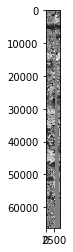

In [ ]:
#imgarr is the 2d numpy array of low resolution image
imgarr=imgarr.astype('float32')

# Function for min-max standardization
def min_max_standardization(imgarr):
  min = np.min(imgarr)
  max = np.max(imgarr)
  imgarr = (imgarr - min)/(max - min)
  return imgarr

imgarr_new = min_max_standardization(imgarr)

#Combined(model_stage1_path,model_stage2_path)
final_model=Combined('/content/drive/MyDrive/Model/CSASR_model_stage1_state_dict','/content/drive/MyDrive/Model/CSASR_model_stage1_state_dict',{'device':'cuda'})
output=final_model(imgarr_new)